# **TP2 - Ciencia de Datos**

### **Ejercicio 1 - Análisis Exploratorio**

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score

import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Esteban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Lectura del Dataset**

In [181]:
# Lectura del dataset
df = pd.read_csv('tweets_hate_speech.csv')

# Vista de los datos
df.head()

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive


#### **Preprocesamiento de Textos**

In [182]:
def clean_text(text):
    text = text.lower() # pasar a minúsculas
    text = ''.join([char for char in text if char not in string.punctuation]) # Eliminar signos de puntuación
    tokens = text.split() # Divide el texto en una lista de palabras usando espacios 
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3] # Elimina las stop words. También elimina las palabras con 3 letras o menos
    return " ".join(tokens) # Vuelve a unir las palabras importantes filtradas en un solo string

df['clean_text'] = df['tweet'].apply(clean_text)

In [183]:
df['clean_text']

0        mayasolovely woman shouldnt complain cleaning ...
1                       mleew17 dats coldtyga cuffin place
2        urkindofbrand dawg 80sbaby4life ever fuck bitc...
3                    cganderson vivabased look like tranny
4        shenikaroberts shit hear might true might fake...
                               ...                        
24778    yous muthafin 8220lifeasking 20pearls coreyema...
24779    youve gone broke wrong heart baby drove rednec...
24780             young buck wanna nigguh like aint fuckin
24781                        youu wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: clean_text, Length: 24783, dtype: object

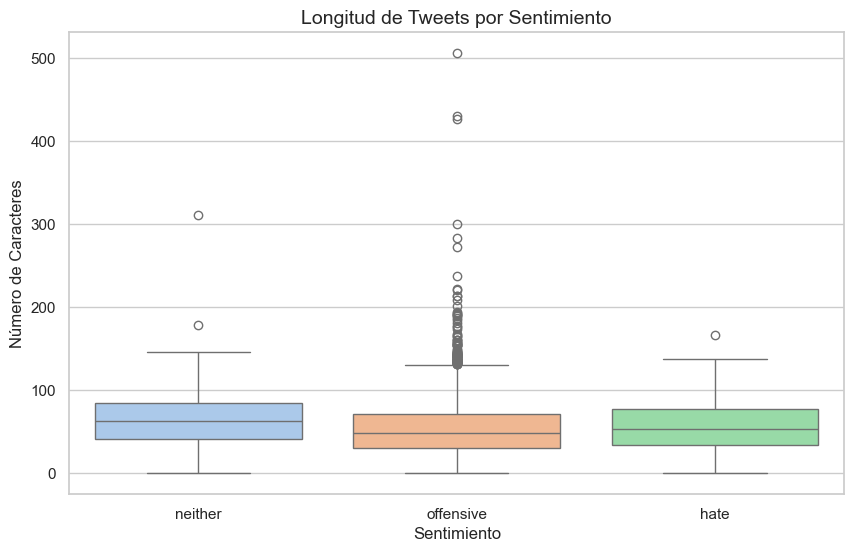

In [184]:
df['length'] = df['clean_text'].apply(len)

# Estilo de Seaborn
sns.set(style="whitegrid")


# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='length', hue='label', palette='pastel', legend=False)

# Títulos y etiquetas
plt.title("Longitud de Tweets por Sentimiento", fontsize=14)
plt.xlabel("Sentimiento", fontsize=12)
plt.ylabel("Número de Caracteres", fontsize=12)

plt.show()

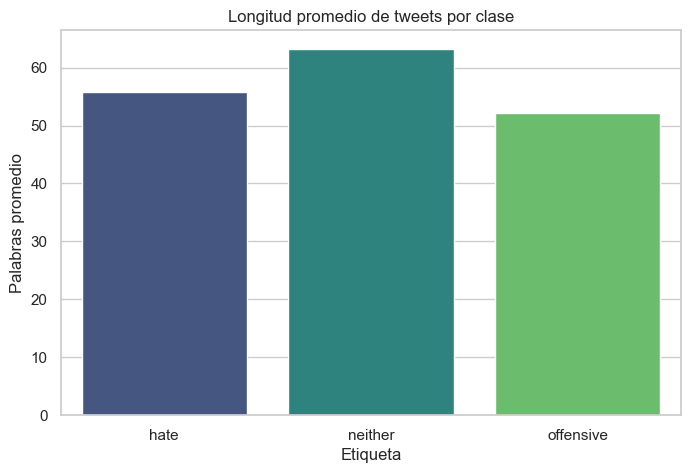

In [185]:
# Longitud promedio de tweets por clase
length_avg = df.groupby('label')['length'].mean().reset_index()

# Visualizar la longitud promedio de tweets por clase
plt.figure(figsize=(8, 5))
sns.barplot(x='label', y='length', hue='label', data=length_avg, palette='viridis', legend=False)
plt.title('Longitud promedio de tweets por clase')
plt.ylabel('Palabras promedio')
plt.xlabel('Etiqueta')
plt.show()

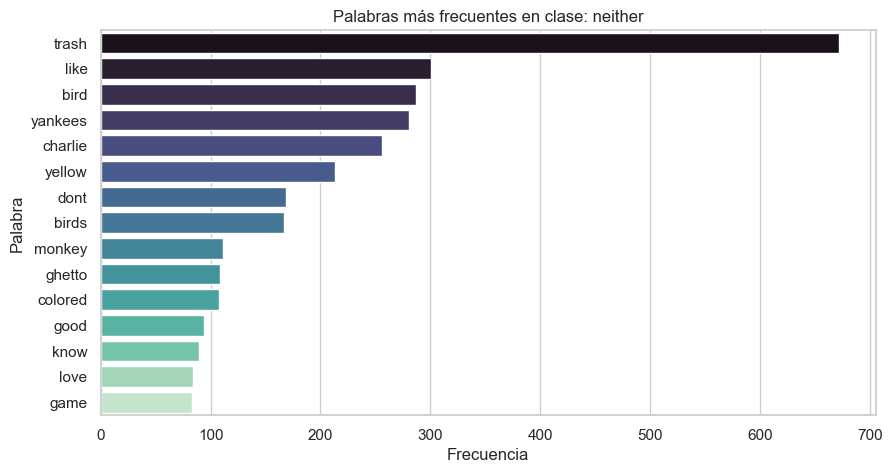

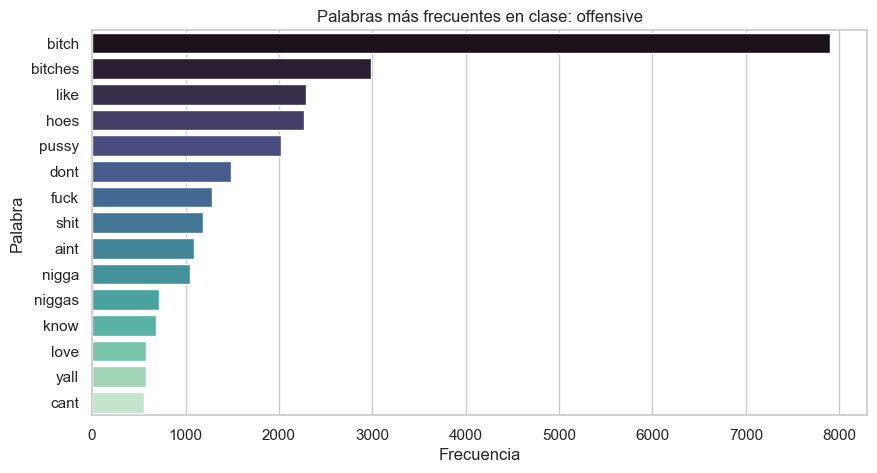

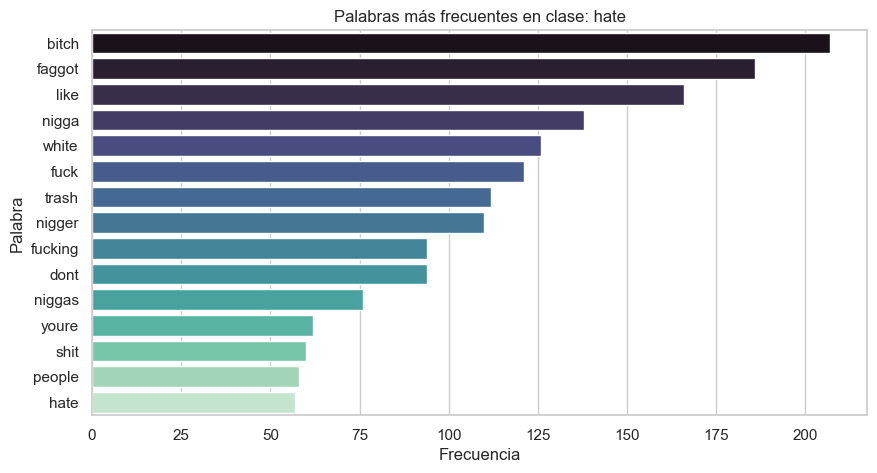

In [186]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_words(label, n=15):
    subset = df[df['label'] == label]
    # Aquí split para obtener listas de palabras desde la columna string clean_text
    all_words = [word for text in subset['clean_text'] for word in text.split()]
    most_common = Counter(all_words).most_common(n)
    words, freqs = zip(*most_common)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(freqs), y=list(words), hue=list(words), palette='mako', legend=False)
    plt.title(f'Palabras más frecuentes en clase: {label}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.show()

# Graficar palabras más comunes por clase
for label in df['label'].unique():
    plot_top_words(label)


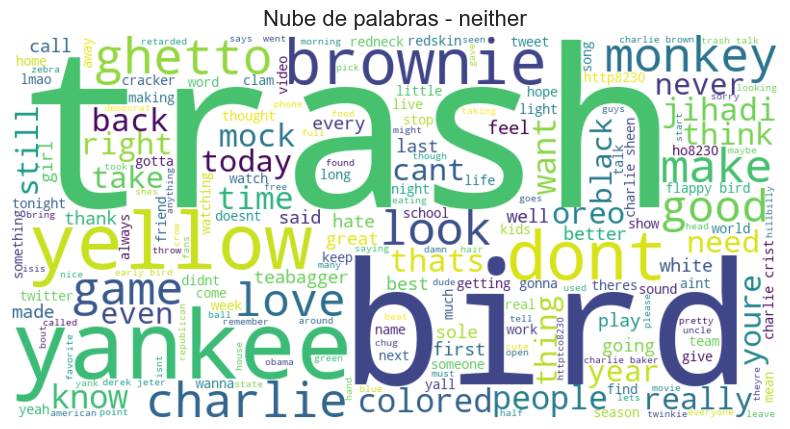

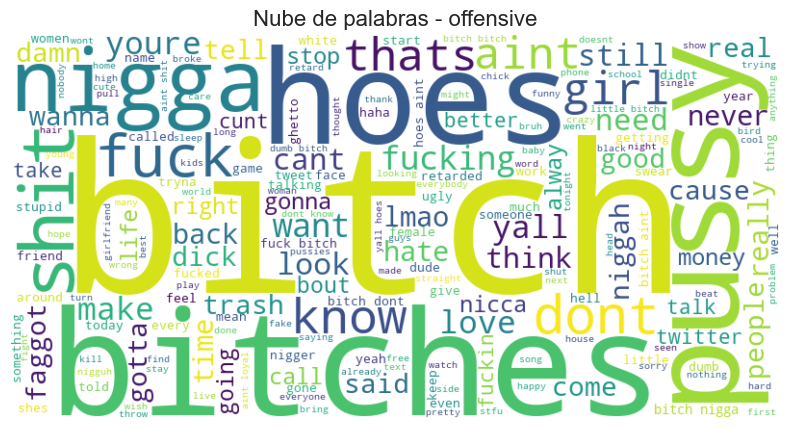

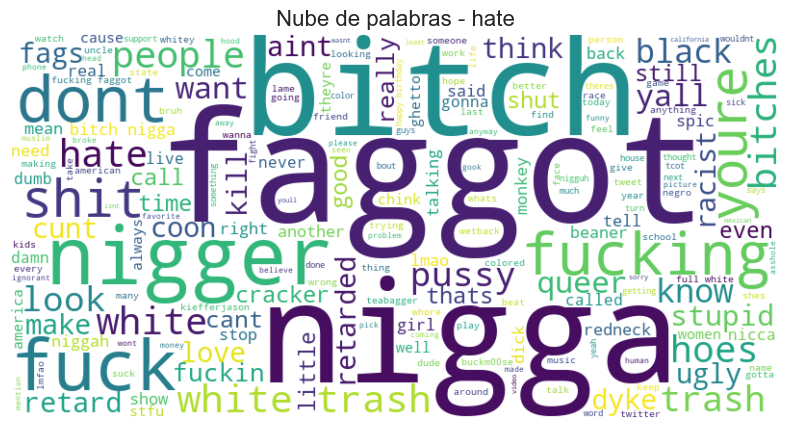

In [187]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(label):
    subset = df[df['label'] == label]
    # Unir todas las palabras de clean_text por cada tweet
    all_words = " ".join(subset['clean_text'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de palabras - {label}', fontsize=16)
    plt.axis('off')
    plt.show()

for label in df['label'].unique():
    generate_wordcloud(label)


## **Ejercicio 2 - Procesamiento del conjunto de datos**

In [188]:
# Convertir sentimiento a números
label_encoder = LabelEncoder()
df['label_num'] = label_encoder.fit_transform(df['label'])  # Guarda el target (sentimientos) como números 0: offensive, 1: neither, 2: hate

In [189]:
df['label'].value_counts()

label
offensive    19190
neither       4163
hate          1430
Name: count, dtype: int64

In [190]:
df['label_num'].value_counts()

label_num
2    19190
1     4163
0     1430
Name: count, dtype: int64

In [191]:
y = df['label_num']

#### **Representación del lenguaje con BoW (Bag of Words)**

In [192]:
bow = CountVectorizer(max_features=5000)
X_bow = bow.fit_transform(df['clean_text'])

In [193]:
X_bow.shape

(24783, 5000)

In [194]:
X_bow

<24783x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 132096 stored elements in Compressed Sparse Row format>

#### **Representación del lenguaje con TF-IDF**

In [195]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

In [196]:
X_tfidf.shape

(24783, 5000)

In [197]:
X_tfidf

<24783x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 132096 stored elements in Compressed Sparse Row format>

#### **Filas vacias**

In [ ]:
# Para Bag of Words
non_empty_bow = X_bow.getnnz(axis=1) > 0 # filas que no estan vacias
print("Filas completamente vacías:", np.sum(~non_empty_bow))

# Para TF-IDF
non_empty_tfidf = X_tfidf.getnnz(axis=1) > 0
print("Filas completamente vacías:", np.sum(~non_empty_tfidf))

Filas completamente vacías: 183
Filas completamente vacías: 183


In [ ]:
# Para Bag of Words
X_bow = X_bow[non_empty_bow] # nos quedamos con las que no están vacía
y_bow = y.values[non_empty_bow]

# Para TF-IDF
X_tfidf = X_tfidf[non_empty_tfidf]
y_tfidf = y.values[non_empty_tfidf]


In [200]:
print("Filas vacías eliminadas (BoW):", np.sum(~non_empty_bow))
print("Filas vacías eliminadas (TF-IDF):", np.sum(~non_empty_tfidf))

Filas vacías eliminadas (BoW): 183
Filas vacías eliminadas (TF-IDF): 183


In [ ]:
# Para Bag of Words
non_empty_bow = X_bow.getnnz(axis=1) > 0
print("Filas completamente vacías:", np.sum(~non_empty_bow))

# Para TF-IDF
non_empty_tfidf = X_tfidf.getnnz(axis=1) > 0
print("Filas completamente vacías:", np.sum(~non_empty_tfidf))

In [201]:
X_tfidf.shape

(24600, 5000)

#### **Balance del conjunto de datos**

<Axes: xlabel='count', ylabel='label_num'>

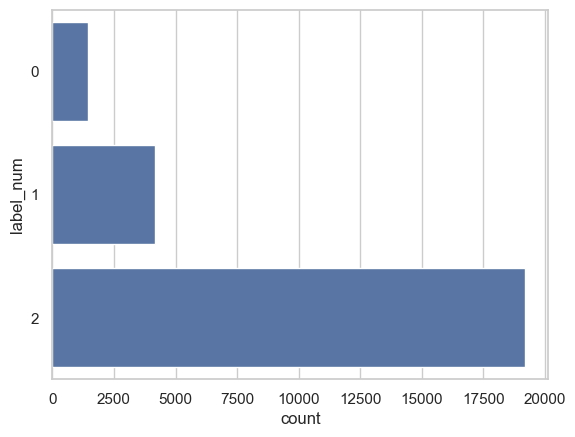

In [202]:
sns.countplot(data=df, y=y)

In [203]:
# SMOTE para balancear ambos conjuntos de datos
smote = SMOTE()

# Para BoW
X_bow_res, y_bow_res = smote.fit_resample(X_bow, y_bow)

# Para TF-IDF
X_tfidf_res, y_tfidf_res = smote.fit_resample(X_tfidf, y_tfidf)

# Verificamos
print("Distribución balanceada BoW:")
print(pd.Series(y_bow_res).value_counts())

# Verificamos
print("Distribución balanceada TF-IDF:")
print(pd.Series(y_tfidf_res).value_counts())

Distribución balanceada BoW:
1    19064
2    19064
0    19064
Name: count, dtype: int64
Distribución balanceada TF-IDF:
1    19064
2    19064
0    19064
Name: count, dtype: int64


<Axes: xlabel='count'>

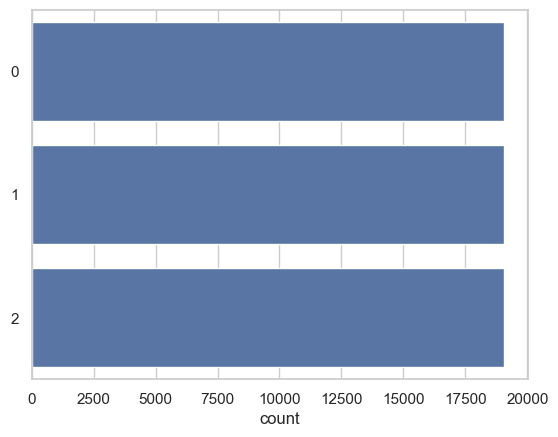

In [204]:
sns.countplot(y=y_bow_res)

In [205]:
#Verificar el tipo y forma de la matriz resultante
print(type(X_bow_res)) # Debería ser <class 'scipy.sparse._csr.csr_matrix'>
print("Forma X_bow_res:", X_bow_res.shape) # Cantidad de muestras y features (e.g., (10000, 5000))
print(type(X_tfidf_res)) 
print("Forma X_tfidf_res:", X_tfidf_res.shape)

<class 'scipy.sparse._csr.csr_matrix'>
Forma X_bow_res: (57192, 5000)
<class 'scipy.sparse._csr.csr_matrix'>
Forma X_tfidf_res: (57192, 5000)


In [206]:
# Chequeo de la distribución de clases después del balanceo
print("Distribución de clases después del balanceo (BoW):")
print(pd.Series(y_bow_res).value_counts())
print(pd.Series(y_bow_res).head())
print("Distribución de clases después del balanceo (TF-IDF):")
print(pd.Series(y_tfidf_res).value_counts())
print(pd.Series(y_tfidf_res).head())

Distribución de clases después del balanceo (BoW):
1    19064
2    19064
0    19064
Name: count, dtype: int64
0    1
1    2
2    2
3    2
4    2
dtype: int32
Distribución de clases después del balanceo (TF-IDF):
1    19064
2    19064
0    19064
Name: count, dtype: int64
0    1
1    2
2    2
3    2
4    2
dtype: int32


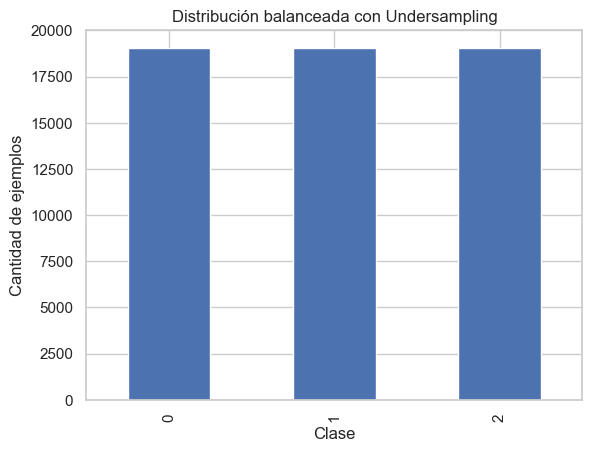

In [207]:
pd.Series(y_bow_res).value_counts().sort_index().plot(kind='bar')

plt.title('Distribución balanceada con Undersampling')
plt.xlabel('Clase')
plt.ylabel('Cantidad de ejemplos')
plt.show()

In [208]:
# Verificacion de formas original y balanceado
print("Tamaño original:", X_tfidf.shape, y_tfidf.shape)
print("Tamaño tras balanceo:", X_tfidf_res.shape, y_tfidf_res.shape)
print("Tamaño original:", X_bow.shape, y_bow.shape)
print("Tamaño tras balanceo:", X_bow_res.shape, y_bow_res.shape)

Tamaño original: (24600, 5000) (24600,)
Tamaño tras balanceo: (57192, 5000) (57192,)
Tamaño original: (24600, 5000) (24600,)
Tamaño tras balanceo: (57192, 5000) (57192,)


## **Ejercicio 3 - Modelado**

#### **División dataset en train/test**

In [209]:
# Dividir el dataset en train, validation y test

# === Para BoW ===
# Paso 1: 80% train+val, 20% test
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(
    X_bow_res, y_bow_res, test_size=0.2, random_state=42, stratify=y_bow_res
)

# === Para TF-IDF ===
# Paso 1: 80% train+val, 20% test
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf_res, y_tfidf_res, test_size=0.2, random_state=42, stratify=y_tfidf_res
)

# Verificación de tamaños
print("=== BoW ===")
print(f"Train: {X_bow_train.shape}, Test: {X_bow_test.shape}")

print("=== TF-IDF ===")
print(f"Train: {X_tfidf_train.shape}, Test: {X_tfidf_test.shape}")


=== BoW ===
Train: (45753, 5000), Test: (11439, 5000)
=== TF-IDF ===
Train: (45753, 5000), Test: (11439, 5000)


#### **Busqueda de hiperparametros**

#### Bosque aleatorio

In [210]:
# Entrena el modelo con todas las combinaciones posibles para Bosque
from sklearn.model_selection import GridSearchCV

param_grid_RF = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

grid_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_RF,
    cv=5, # cantidad de folds para validación cruzada
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [211]:
# entrenar con Bolsa
grid_RF.fit(X_bow_train, y_bow_train)
best_param_bow_RF = grid_RF.best_params_
print("Mejores parámetros:", grid_RF.best_params_)
print("Mejor score:", grid_RF.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mejor score: 0.8191157059487063


In [212]:
# establecemos los mejores hiperparametros de bow
criterion_bow = best_param_bow_RF.get('criterion')
max_depth_bow = best_param_bow_RF.get('max_depth')
min_samples_leaf_bow = best_param_bow_RF.get('min_samples_leaf')
min_samples_split_bow = best_param_bow_RF.get('min_samples_split')
n_estimators_bow = best_param_bow_RF.get('n_estimators')

#### Regresión

In [213]:
param_grid_LR = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_LR = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid_LR,
    cv=5, # cantidad de folds para validación cruzada
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [214]:
# entrenar con Bolsa
grid_LR.fit(X_bow_train, y_bow_train)
best_param_bow_LR = grid_LR.best_params_
print("Mejores parámetros:", grid_LR.best_params_)
print("Mejor score:", grid_LR.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor score: 0.8430267336186494


In [215]:
c_bow = best_param_bow_LR.get('C')
penalty_bow = best_param_bow_LR.get('penalty')
solver_bow = best_param_bow_LR.get('solver')

#### Naive Bayes

In [216]:
param_grid_NB = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

grid_NB = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid_NB,
    cv=5, # cantidad de folds para validación cruzada
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [217]:
# entrenar con Bolsa
grid_NB.fit(X_bow_train, y_bow_train)
best_param_bow_NB = grid_NB.best_params_
print("Mejores parámetros:", grid_NB.best_params_)
print("Mejor score:", grid_NB.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros: {'alpha': 0.1, 'fit_prior': False}
Mejor score: 0.8163837521415139


In [218]:
alpha_bow = best_param_bow_NB.get('alpha')
fit_prior_bow = best_param_bow_NB.get('fit_prior')

#### **Definir modelos de AA**

In [219]:
models = {
    "Logistic Regression": LogisticRegression(
                                                C = c_bow,
                                                penalty = penalty_bow,
                                                solver = solver_bow,
                                                max_iter=1000),
    "Random Forest": RandomForestClassifier(
                                                criterion = criterion_bow,
                                                max_depth = max_depth_bow,
                                                min_samples_leaf = min_samples_leaf_bow,
                                                min_samples_split = min_samples_split_bow,
                                                n_estimators = n_estimators_bow),
    "Naive Bayes": MultinomialNB(alpha = alpha_bow, fit_prior = fit_prior_bow)
}

#### **Entrenar y evaluar modelos**

In [220]:
# Guardar los resultados
resultados_accuracy = []

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_models(X_train, X_test, y_train, y_test, vectorizer_name):
    print(f"\nResultados con {vectorizer_name}:\n" + "-"*40)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"\nModelo: {name}")
        print("Accuracy:", acc)
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

        # Guardar resultados
        resultados_accuracy.append({
            'Modelo': name,
            'Vectorización': vectorizer_name,
            'Accuracy': acc
        })

        # Mostrar matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Matriz de Confusión - {name} ({vectorizer_name})")
        plt.tight_layout()
        plt.show()


Resultados con Bag of Words:
----------------------------------------

Modelo: Logistic Regression
Accuracy: 0.8464900778040039
              precision    recall  f1-score   support

        hate       0.77      0.89      0.83      3813
     neither       0.89      0.81      0.85      3813
   offensive       0.90      0.84      0.87      3813

    accuracy                           0.85     11439
   macro avg       0.85      0.85      0.85     11439
weighted avg       0.85      0.85      0.85     11439



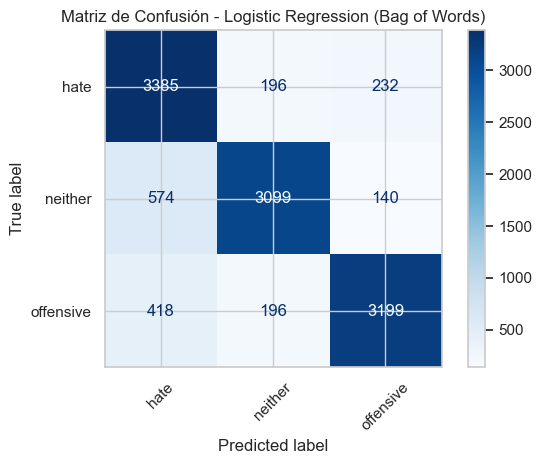


Modelo: Random Forest
Accuracy: 0.8255966430632048
              precision    recall  f1-score   support

        hate       0.72      0.92      0.81      3813
     neither       0.87      0.84      0.85      3813
   offensive       0.95      0.72      0.82      3813

    accuracy                           0.83     11439
   macro avg       0.84      0.83      0.83     11439
weighted avg       0.84      0.83      0.83     11439



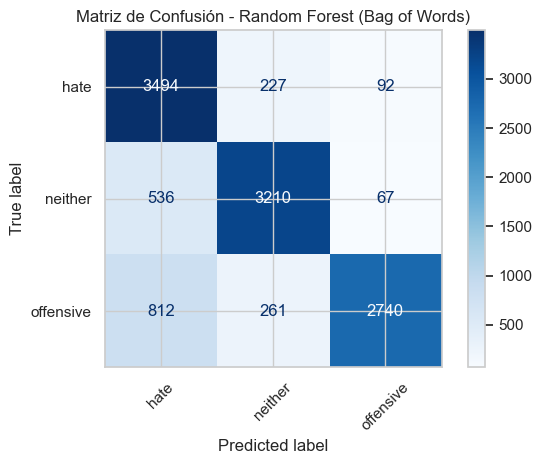


Modelo: Naive Bayes
Accuracy: 0.8191275461141708
              precision    recall  f1-score   support

        hate       0.79      0.80      0.79      3813
     neither       0.90      0.77      0.83      3813
   offensive       0.78      0.89      0.83      3813

    accuracy                           0.82     11439
   macro avg       0.83      0.82      0.82     11439
weighted avg       0.83      0.82      0.82     11439



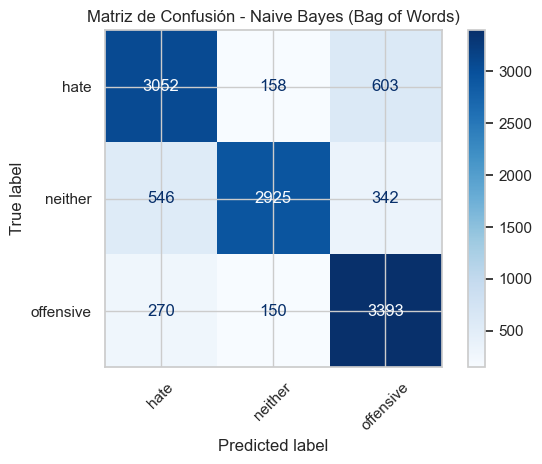

In [221]:
# Evaluación con BoW
evaluate_models(X_bow_train, X_bow_test, y_bow_train, y_bow_test, "Bag of Words")

#### TF-IDF

#### Bosque aleatorio

In [222]:
# entrenar con TF-IDF
grid_RF.fit(X_tfidf_train, y_tfidf_train)
best_param_tfidf_RF = grid_RF.best_params_
print("Mejores parámetros:", grid_RF.best_params_)
print("Mejor score:", grid_RF.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score: 0.958079299762993


In [223]:
# establecemos los mejores hiperparametros de bow
criterion_tfidf = best_param_tfidf_RF.get('criterion')
max_depth_tfidf = best_param_tfidf_RF.get('max_depth')
min_samples_leaf_tfidf = best_param_tfidf_RF.get('min_samples_leaf')
min_samples_split_tfidf = best_param_tfidf_RF.get('min_samples_split')
n_estimators_tfidf = best_param_tfidf_RF.get('n_estimators')

#### Regresión

In [224]:
# entrenar con Bolsa
grid_LR.fit(X_tfidf_train, y_tfidf_train)
best_param_tfidf_LR = grid_LR.best_params_
print("Mejores parámetros:", grid_LR.best_params_)
print("Mejor score:", grid_LR.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor score: 0.9215789369969419


In [225]:
c_tfidf = best_param_tfidf_LR.get('C')
penalty_tfidf = best_param_tfidf_LR.get('penalty')
solver_tfidf = best_param_tfidf_LR.get('solver')

#### Naive Bayes

In [226]:
# entrenar con Bolsa
grid_NB.fit(X_tfidf_train, y_tfidf_train)
best_param_tfidf_NB = grid_NB.best_params_
print("Mejores parámetros:", grid_NB.best_params_)
print("Mejor score:", grid_NB.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros: {'alpha': 0.1, 'fit_prior': True}
Mejor score: 0.8810787963691149


In [227]:
alpha_tfidf = best_param_tfidf_NB.get('alpha')
fit_prior_tfidf = best_param_tfidf_NB.get('fit_prior')

### Definir modelos

In [228]:
models = {
    "Logistic Regression": LogisticRegression(
                                                C = c_tfidf,
                                                penalty = penalty_tfidf,
                                                solver = solver_tfidf,
                                                max_iter=1000),
    "Random Forest": RandomForestClassifier(
                                                criterion = criterion_tfidf,
                                                max_depth = max_depth_tfidf,
                                                min_samples_leaf = min_samples_leaf_tfidf,
                                                min_samples_split = min_samples_split_tfidf,
                                                n_estimators = n_estimators_tfidf),
    "Naive Bayes": MultinomialNB(alpha = alpha_tfidf, fit_prior = fit_prior_tfidf)
}


Resultados con TF-IDF:
----------------------------------------

Modelo: Logistic Regression
Accuracy: 0.9272663694378879
              precision    recall  f1-score   support

        hate       0.90      0.96      0.93      3813
     neither       0.94      0.97      0.96      3813
   offensive       0.94      0.85      0.89      3813

    accuracy                           0.93     11439
   macro avg       0.93      0.93      0.93     11439
weighted avg       0.93      0.93      0.93     11439



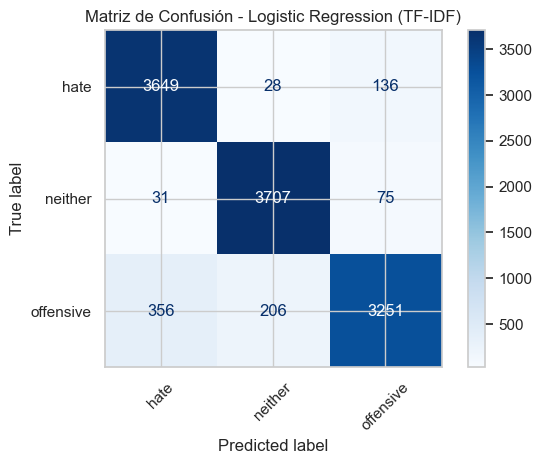


Modelo: Random Forest
Accuracy: 0.960223795786345
              precision    recall  f1-score   support

        hate       0.96      0.98      0.97      3813
     neither       0.96      0.97      0.97      3813
   offensive       0.96      0.93      0.94      3813

    accuracy                           0.96     11439
   macro avg       0.96      0.96      0.96     11439
weighted avg       0.96      0.96      0.96     11439



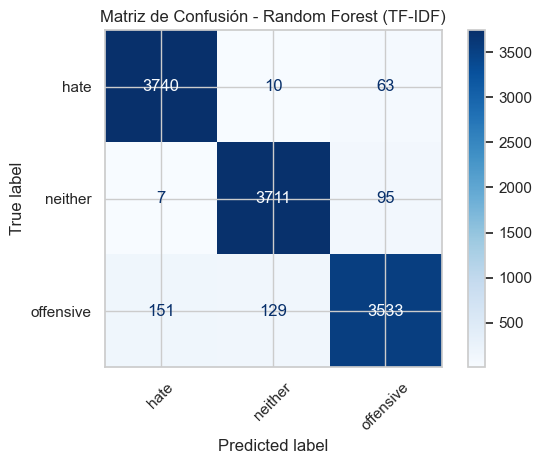


Modelo: Naive Bayes
Accuracy: 0.8855669201853309
              precision    recall  f1-score   support

        hate       0.87      0.90      0.88      3813
     neither       0.93      0.93      0.93      3813
   offensive       0.86      0.83      0.84      3813

    accuracy                           0.89     11439
   macro avg       0.89      0.89      0.89     11439
weighted avg       0.89      0.89      0.89     11439



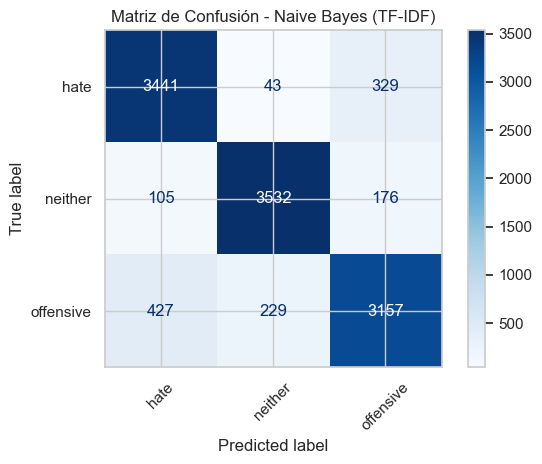

In [229]:
# Evaluación con TF-IDF
evaluate_models(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

#### **Resultados**

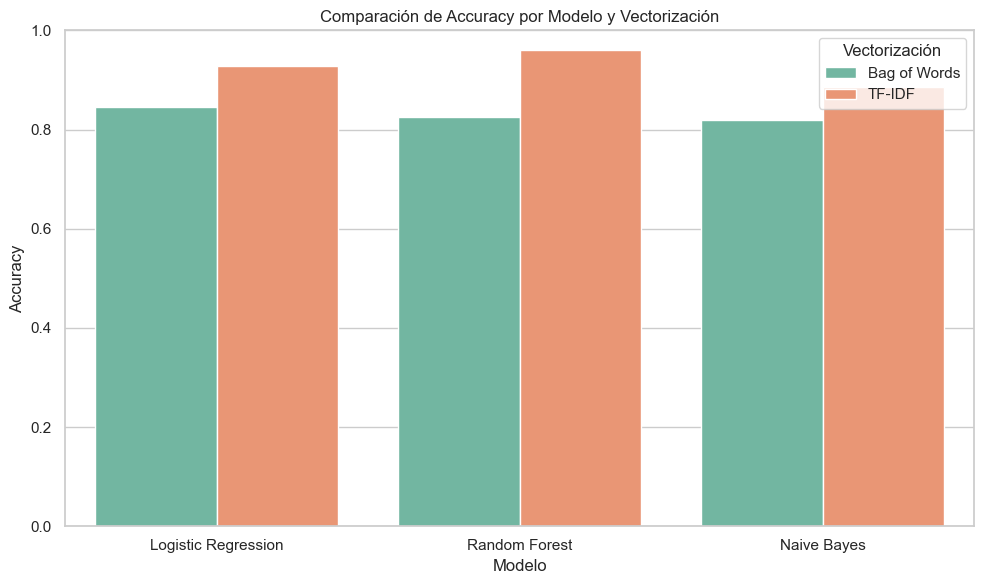

In [230]:
df_results = pd.DataFrame(resultados_accuracy)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Modelo', y='Accuracy', hue='Vectorización', palette='Set2')
plt.title('Comparación de Accuracy por Modelo y Vectorización')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()